#Import SKTIME Library

In [1]:
!pip install sktime[all_extras]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 4.4 MB/s 
     |████████████████████████████████| 57 kB 3.0 MB/s 
     |████████████████████████████████| 228 kB 10.3 MB/s 
     |████████████████████████████████| 97 kB 2.9 MB/s 
     |████████████████████████████████| 136 kB 39.0 MB/s 
     |████████████████████████████████| 1.4 MB 38.5 MB/s 
     |████████████████████████████████| 11.2 MB 33.2 MB/s 
     |████████████████████████████████| 177 kB 45.9 MB/s 
     |████████████████████████████████| 134 kB 39.4 MB/s 
     |████████████████████████████████| 634 kB 38.3 MB/s 
     |████████████████████████████████| 7.5 MB 28.8 MB/s 
     |████████████████████████████████| 793 kB 42.4 MB/s 
     |████████████████████████████████| 2.5 MB 38.7 MB/s 
     |████████████████████████████████| 43 kB 694 kB/s 
     |████████████████████████████████| 6.9 MB 37.9 MB/s 
     |███████████████████████████████

In [2]:
#some issues come up with newer version of matplotlib when using SKTIME
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


#Other Imports

In [3]:
#Import libraries

#for importing modules
import os
import requests
from google.colab import drive

import timeit

import pandas as pd
import requests
import numpy as np
from datetime import date, datetime
from matplotlib.ticker import MaxNLocator

#for visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

#for potential interactivity
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
from warnings import simplefilter

simplefilter("ignore", category=UserWarning)

In [4]:
#SKlearn imports
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

#for distance metrics to find similarity btw time series
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# for dynamic time warping
# from dtaidistance import dtw
# from dtaidistance import dtw_visualisation as dtwvis

#statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

#plotting
from sktime.utils.plotting import plot_series
from sktime.utils import plotting

#forecast setup
from sktime.datasets import load_airline, load_shampoo_sales

from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.registry import all_estimators
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import MedianAbsolutePercentageError

from sktime.forecasting.model_evaluation import evaluate

from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.regression.compose import ComposableTimeSeriesForestRegressor

# from sktime.forecasting.all import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
                                              ForecastingGridSearchCV,
                                              SingleWindowSplitter,
                                              SlidingWindowSplitter,
                                              ExpandingWindowSplitter
                                              )


#forecasters
from sktime.forecasting.naive import NaiveVariance
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.trend import PolynomialTrendForecaster
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

from sktime.forecasting.compose import BaggingForecaster
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.compose import StackingForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.online_learning import (
                                              NormalHedgeEnsemble,
                                              OnlineEnsembleForecaster,
                                                )


#classification
from sktime.classification.interval_based import TimeSeriesForestClassifier

#Setup

In [5]:
# Mount Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive')

# Set root path
root_path = '/content/drive/Shareddrives/capstone-power-grid-protagonists/project'

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [6]:
#notebooks directory
notebook_path = root_path+'/notebooks'
os.chdir(notebook_path)

In [7]:
# Verifying the current working directory is the notebook folder/directory
%pwd

'/content/drive/Shareddrives/capstone-power-grid-protagonists/project/notebooks'

#Get data from EIA's API

Applying pipeline listed in the 01_data_collection pipeline notebook

In [8]:
#Get the most recent list of balancing authorities as recognized on the EIA-930 survey form

url = 'https://www.eia.gov/electricity/930-content/EIA930_Reference_Tables.xlsx'

def get_eia930_ba_list(eia930_location_url):
  '''
  Get the most recent list of balancing authorities as recognized on the EIA-930 survey form

  from EIA website: https://www.eia.gov/electricity/gridmonitor/about
  We use BA acronyms based on official NERC BA codes, and so codes may not match the full name of BAs 
  because of changes in corporate ownership, mergers, or other business transactions.
  '''
  eia930_ref_table = pd.read_excel('https://www.eia.gov/electricity/930-content/EIA930_Reference_Tables.xlsx')

  return eia930_ref_table['BA Code'].values

In [9]:
ba_codes = get_eia930_ba_list(url)

####EIA's API
Through EIA's API, the most recent time series data can be directly obtained. This was the data that was used for forecasting tasks in the project.  The code below queries the API for the most up-to-date daily balancing authority data, specifically: Demand(D), Net-Generation(NG), Demand Forecast(DF), and Energy Interchange between neighboring BA's (EI)

**NOTE: In order to access data from the API you must register to obtain a free, access key from the EIA here: [https://www.eia.gov/opendata/](https://www.eia.gov/opendata/)**

In [10]:
def generate_query_url(frequency='daily', data_type='D', ba_code=None, api_key=None):
  if frequency=='daily':
    desired_dataset = 'daily-region-data'
    api_route = f'electricity/rto/{desired_dataset}'
    query_url = f'https://api.eia.gov/v2/{api_route}/data?api_key={api_key}&data[]=value&facets[respondent][]={ba_code}&facets[type][]={data_type}&facets[timezone][]=Eastern&frequency={frequency}&length=500000'
    return query_url
  else:
    return print('This function currently only supports frequency="daily".')

In [11]:
def api_query_df_generation(query_url):
  try:
    r = requests.get(query_url)

    #convert data to json file
    json_data_ba = r.json()

    #put response-level data into pandas df with the keys as columns
    df_ba = pd.DataFrame.from_dict(json_data_ba['response']['data'], orient='columns')

    return df_ba

  except:
    return print(f'Issue with generating df from API request for {ba_code}')

In [12]:
def clean_df_generated_from_api(df_ba):
  try:
    #make a copy of the df before manipulation
    df_ba_copy = df_ba.copy()

    #get ba_code from df
    respondent_ba = df_ba_copy.respondent.unique()[0]

    #get data_type from df
    data_type = df_ba_copy.type.unique()[0]

    #reducing the number of needed columns for forecasting
    df_ba_copy = df_ba_copy[['period','respondent','value']]

    #so info is not lost about what the data is (NG) and what unit it is measured in (MegaWatt-hours) I changed the name of the column
    df_ba_copy.rename(columns={'value':f'{respondent_ba}_{data_type}(MW-h)'}, inplace=True)
    df_ba_copy.drop('respondent', axis=1, inplace=True)
    return df_ba_copy
  except:
    return print(f'Issue with cleaning df for {ba_code}')

In [13]:
def export_df_as_csv_to_folder(df_ba_copy, ba_code, data_path):
  try:
    #give name to DataFrame
    from pandas.core.frame import DataFrame
    df_ba_copy.name = f'{ba_code}_df'
    
    #getting the startdate of the dataset for file naming purposes
    data_start_date = df_ba_copy.period[0]

    #getting the enddate of the dataset for file naming purposes
    data_end_date = df_ba_copy.period[len(df_ba_copy)-1]

    #getting the data name for dataset naming purposes
    dataset_info = df_ba_copy.columns[1]

    #exporting the data as a CSV
    df_ba_copy.to_csv(f'{data_path}{dataset_info}_({data_start_date} to {data_end_date}).csv')

    print(f'{df_ba_copy.name} successfully exported to location {data_path}{dataset_info}_({data_start_date} to {data_end_date}).csv')
  
    file_location = f'{data_path}{dataset_info}_({data_start_date} to {data_end_date}).csv'
    return file_location
    
  except:
    return print(f'Issue with exporting the df for {ba_code}')

##### Get Data for All Available Balancing Authorities

In [14]:
# def run_pipeline_for_all_ba(ba_list_eia930,frequency, data_type):
#   for ba_code in ba_list_eia930:
#   #running the pipeline for ba
#   url_output = generate_query_url(frequency, data_type, ba_code, paul_key)
#   df_generated = api_query_df_generation(url_output)
#   df_cleaned = clean_df_generated_from_api(df_generated)
#   export_df_as_csv_to_folder(df_cleaned, ba_code, data_path)

#Load Data

In [15]:
#sample input parameters

#monthly and hourly to come soon
frequency = 'daily'
#can also select NG, DF, or EI (though not all balancing authorities will have data for each categeory)
data_type = 'D'
#sample BA used for illustrations
sample_ba = 'FPL'
#API key --- Paul provided his for the purpose of reproducing results in this SIADS 697 class, but will delete afterwards
paul_api_key = '6e1b1996731d78aa3d7803e2de270e75'

# Set root path & data path
root_path = '/content/drive/Shareddrives/capstone-power-grid-protagonists/project'
data_path = f'{root_path}/data/processed/eia/{frequency}_{data_type}_by_ba/'

In [16]:
#running the pipeline
url_output = generate_query_url(frequency=frequency, data_type=data_type, ba_code=sample_ba, api_key=paul_api_key)
df_generated = api_query_df_generation(url_output)
df_cleaned = clean_df_generated_from_api(df_generated)
file_location = export_df_as_csv_to_folder(df_cleaned, sample_ba, data_path)

FPL_df successfully exported to location /content/drive/Shareddrives/capstone-power-grid-protagonists/project/data/processed/eia/daily_D_by_ba/FPL_D(MW-h)_(2015-07-01 to 2022-08-18).csv


In [17]:
file_location 

'/content/drive/Shareddrives/capstone-power-grid-protagonists/project/data/processed/eia/daily_D_by_ba/FPL_D(MW-h)_(2015-07-01 to 2022-08-18).csv'

In [18]:

fpl_d_ts = pd.read_csv(file_location , usecols=["period", f'{sample_ba}_{data_type}(MW-h)'], parse_dates=["period"])
fpl_d_ts.head()

,period,FPL_D(MW-h)
0,2015-07-01,400334
1,2015-07-02,402900
2,2015-07-03,393779
3,2015-07-04,369219
4,2015-07-05,390277


#Prepping Sample Dataset (D, Daily)

In [19]:
#converting df to a simple date-time series
fpl_d = pd.Series(fpl_d_ts['FPL_D(MW-h)'].values, index=pd.to_datetime(fpl_d_ts['period']))
fpl_d

period
2015-07-01    400334
2015-07-02    402900
2015-07-03    393779
2015-07-04    369219
2015-07-05    390277
               ...  
2022-08-14    422643
2022-08-15    441499
2022-08-16    460565
2022-08-17    481023
2022-08-18    478079
Length: 2606, dtype: int64

#Learning about seasonality and trends in data

In [20]:
def seasonal_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    
    return seasonal_decompose(ser, model)

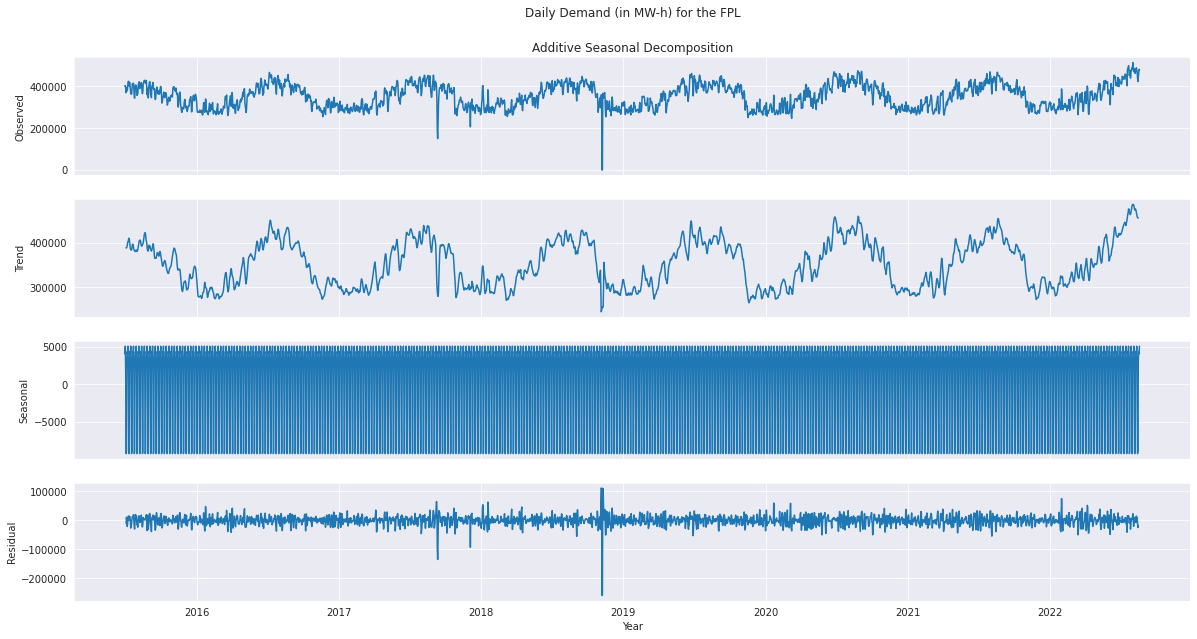

In [21]:
# Plotting and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)
res = seasonal_decomp(fpl_d, model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Year")
fig.suptitle("Daily Demand (in MW-h) for the FPL", x=0.513, y=0.95)

plt.show()

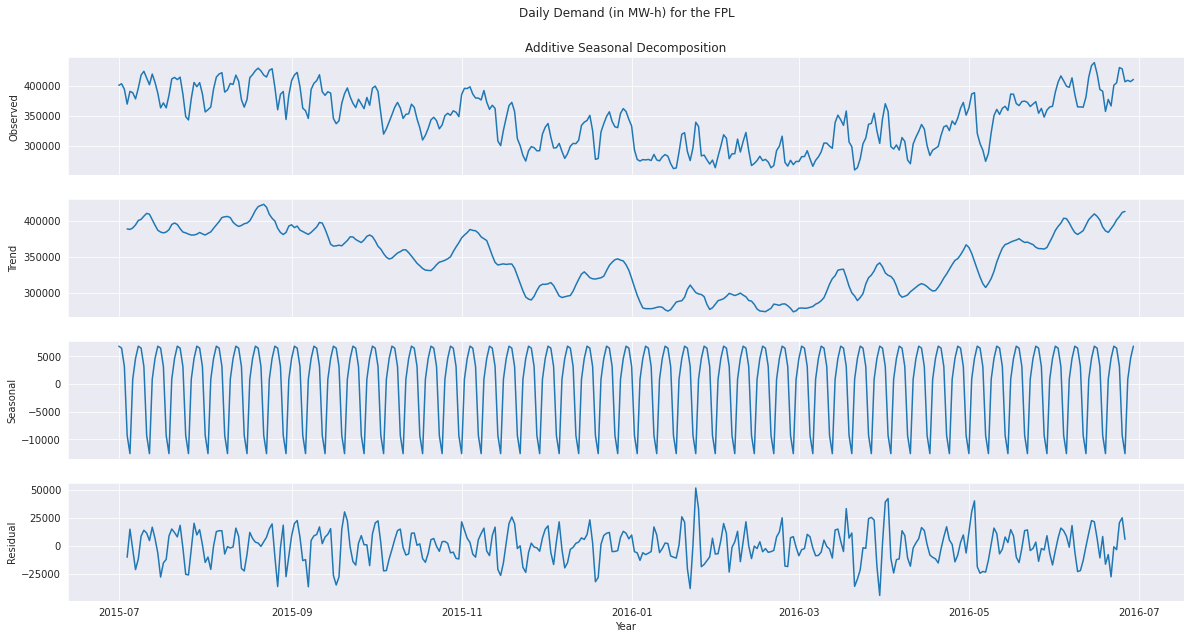

In [22]:
# Plotting and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)
res = seasonal_decomp(fpl_d[:365], model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Year")
fig.suptitle("Daily Demand (in MW-h) for the FPL", x=0.513, y=0.95)

plt.show()

In [23]:
from statsmodels.tsa.stattools import pacf

def calc_pacf(ser, max_lag):
    """
    Takes a series and calculates the PACF
    """
    
    ans_pacf = pacf(ser, nlags=max_lag)
    
    return ans_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Text(0, 0.5, 'Correlation')

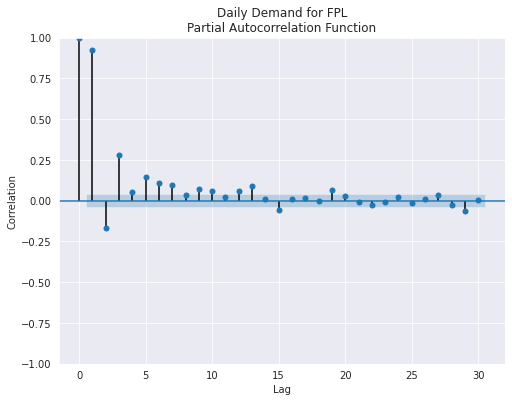

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = fpl_d, 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Daily Demand for FPL\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Text(0, 0.5, 'Correlation')

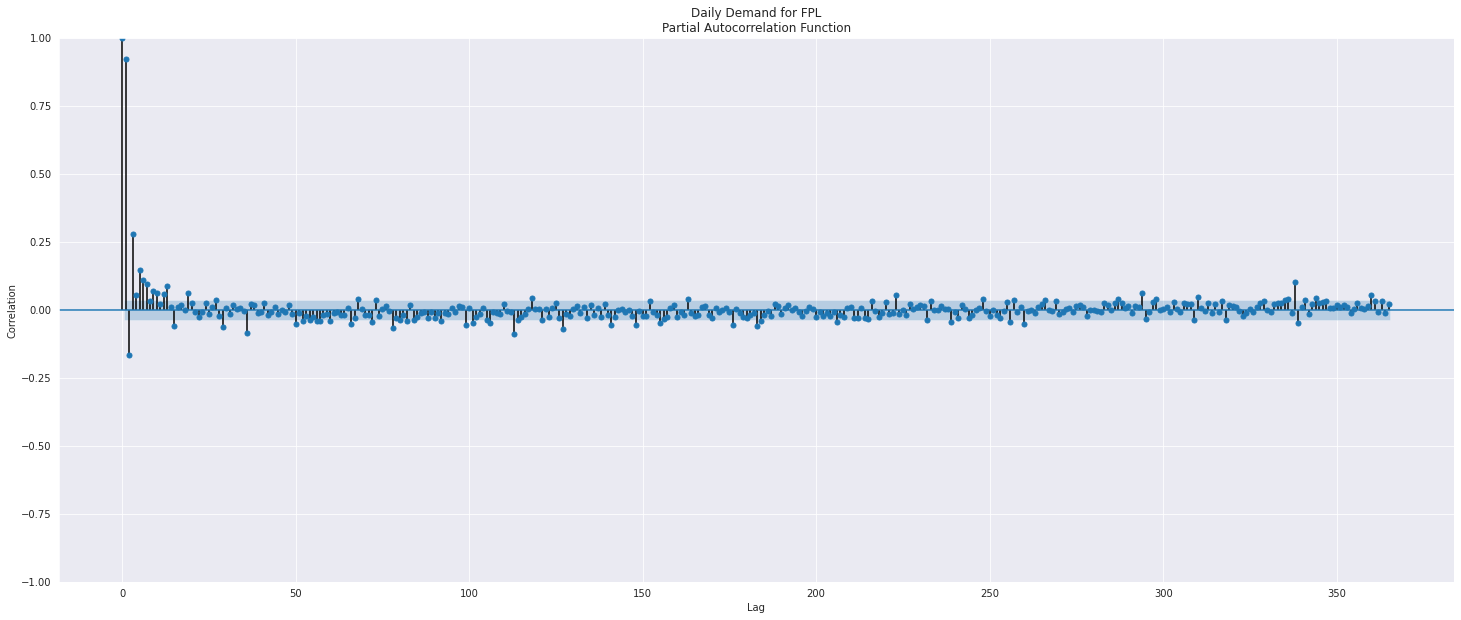

In [25]:
ser, max_lag = fpl_d, 365

fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plot_pacf(ser, ax, lags=max_lag, title="Daily Demand for FPL\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

In [26]:
#performing an Augmented Dickey-Fuller unit root test to show p-value < 0.05

from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(fpl_d)
print(f"p-value: {pval}")

p-value: 0.04163285710606932


#Prepping data for SKTIME

In [27]:
##changing the index type to period:
fpl_d.index = pd.Series(fpl_d.index, dtype="period[D]")

In [29]:
#set frequency to daily
fpl_d = fpl_d.asfreq(freq='D')

In [36]:
y = fpl_d

#temporal train test split
y_train, y_test = temporal_train_test_split(y, test_size=365)

In [37]:
# using indices from `y_test` for forecasthorizon or np.arange to get the "next" 365 days worth of data (forecast)
fh = ForecastingHorizon(y_test.index, is_relative=False)
# fh = np.arrange(1,366)

##Initial Visuals

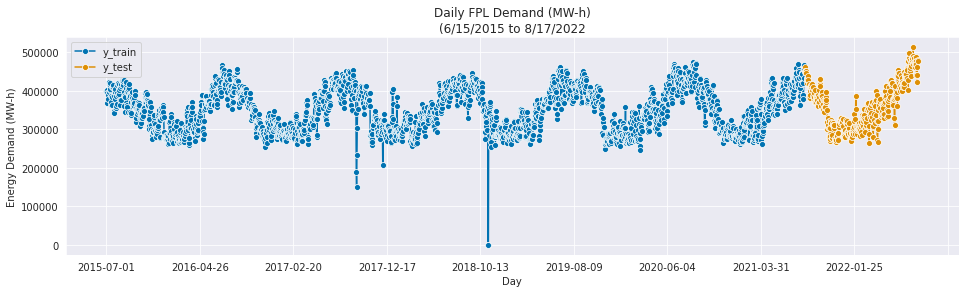

In [46]:
# plotting of train and test data for visualization
plot_series(y_train, y_test, labels=["y_train", "y_test"])
plt.title('Daily FPL Demand (MW-h)\n(6/15/2015 to 8/17/2022')
plt.xlabel("Day")
plt.ylabel("Energy Demand (MW-h)")
plt.show()

#Functions to visualize time-series cross-validation (Expanding Window)

In [47]:
'''
This function came from this article:
https://github.com/alan-turing-institute/sktime/blob/main/examples/window_splitters.ipynb
'''

def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    # ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

In [48]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

# of splits: 15


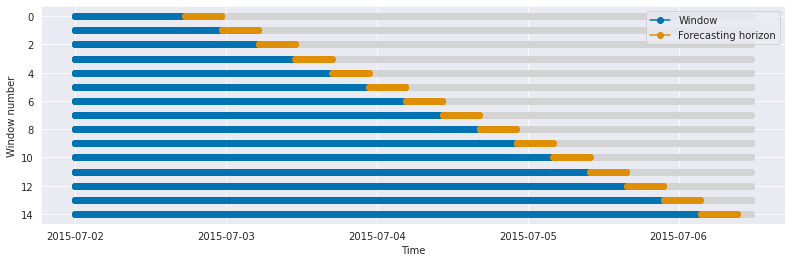

In [55]:

fh = np.arange(1, 122)

#choosing the expanding window
cv = ExpandingWindowSplitter( \
                              initial_window=365,
                              step_length=122,  # 1/3 of a year
                              start_with_window=True,
                              fh=fh
                             )

print(f'# of splits: {cv.get_n_splits(y_train)}')
train_windows, test_windows = get_windows(y_train, cv)
plot_windows(y_train, train_windows, test_windows)

# of splits: 5


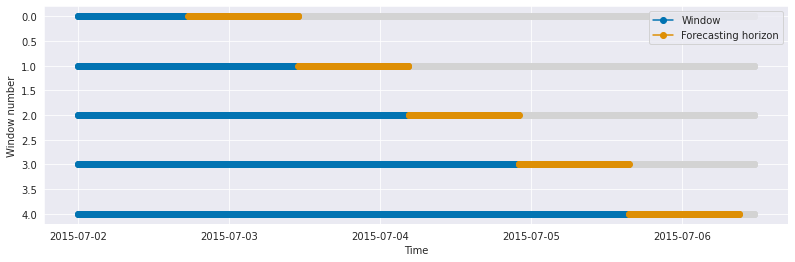

In [54]:
fh = np.arange(1, 366)

#choosing the expanding window
cv = ExpandingWindowSplitter(
                              initial_window=365,
                              step_length=365,  #one year
                              start_with_window=True,
                              fh=fh
                             )

print(f'# of splits: {cv.get_n_splits(y_train)}')
train_windows, test_windows = get_windows(y_train, cv)
plot_windows(y_train, train_windows, test_windows)

#FORECASTERS!

In [ ]:
#parameters
sp = 365
random_state = 697

In [ ]:
#metaregressors tested

baysian_ridge = BayesianRidge()

knr = KNeighborsRegressor(n_neighbors=3,weights='uniform',n_jobs=-1)

rfr = RandomForestRegressor(
                            n_estimators=100,
                            criterion='squared_error',
                            max_depth=3, 
                            bootstrap=False,
                            oob_score=False,
                            n_jobs=-1,
                            random_state=random_state
                            )

gbr = GradientBoostingRegressor(
                                loss='absolute_error',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state
                                ),

bagg_r_rfr = BaggingRegressor(base_estimator=rfr, n_estimators=10,n_jobs=-1, random_state=random_state)
bagg_r_knr = BaggingRegressor(base_estimator=knr, n_estimators=10,n_jobs=-1, random_state=random_state)
bagg_r_gbr = BaggingRegressor(base_estimator=gbr, n_estimators=10,n_jobs=-1, random_state=random_state)

In [ ]:
#top-performing forecast models tested
naive =     ("naive", NaiveForecaster(strategy="last", sp=sp)) 
theta =     ("theta", ThetaForecaster(deseasonalize=True, sp=sp))
ets =       ("exp_smoothing", ExponentialSmoothing(trend = None, seasonal='add', use_boxcox = True, sp=sp, random_state=random_state))
ets_bagg =  ("ets_bagg", BaggingForecaster(STLBootstrapTransformer(n_series=10,sp=sp, random_state=random_state),ets[1],random_state=random_state))
prophet =   ("prophet",  Prophet(freq='D', add_seasonality={'period':sp, 'fourier_order':6, 'name':'fun'}, 
                                growth='linear', 
                                yearly_seasonality='auto', #default 'auto'
                                weekly_seasonality='auto', #default 'auto'
                                daily_seasonality=True,  #default 'auto'
                                seasonality_mode='additive',
                                alpha=0.05))

stacking_nte_br = ("stacking_nte_br", StackingForecaster(forecasters=[naive, theta, ets], regressor=baysian_ridge, n_jobs=-1, random_state=random_state))

stacking_nt_knr = ("stacking_nt_knr", StackingForecaster(forecasters=[naive, theta], regressor=knr, n_jobs=-1, random_state=random_state))

stacking_nt_rfr = ("stacking_nt_rfr", StackingForecaster(forecasters=[naive, theta], regressor=rfr, n_jobs=-1, random_state=random_state))

stacking_nte_bagg_r_rfr = ("stacking_nte_bagg_r_rfr", StackingForecaster(forecasters=[naive, theta, ets], regressor= bagg_r_rfr, n_jobs=-1, random_state=random_state))

stacking_nte_bagg_r_knr = ("stacking_nte_bagg_r_knr", StackingForecaster(forecasters=[naive, theta, ets], regressor= bagg_r_knr, n_jobs=-1, random_state=random_state))

stacking_nte_bagg_r_gbr = ("stacking_nte_bagg_r_gbr", StackingForecaster(forecasters=[naive, theta, ets], regressor= bagg_r_gbr, n_jobs=-1, random_state=random_state))

autoensemble_nte_br = ("autoensemble_nte_br", AutoEnsembleForecaster(forecasters=[naive, theta, ets], regressor= baysian_ridge, n_jobs=-1, random_state=random_state))

autoensemble_nt_knr = ("autoensemble_nt_knr", AutoEnsembleForecaster(forecasters=[naive, theta], regressor= knr, n_jobs=-1, random_state=random_state))

autoensemble_nt_rfr = ("autoensemble_nt_rfr", AutoEnsembleForecaster(forecasters=[naive, theta], regressor= rfr, n_jobs=-1, random_state=random_state))

autoensemble_nt_gbr = ("autoensemble_nt_gbr", AutoEnsembleForecaster(forecasters=[naive, theta], regressor= gbr, n_jobs=-1, random_state=random_state))

autoensemble_ep_rfr = ("autoensemble_ep_rfr", AutoEnsembleForecaster(forecasters=[ets, prophet], regressor= rfr, n_jobs=-1, random_state=random_state))

autoensemble_ep_knr = ("autoensemble_ep_knr", AutoEnsembleForecaster(forecasters=[ets, prophet], regressor= knr, n_jobs=-1, random_state=random_state))

autoensemble_ep_bagg_r_rfr = ("autoensemble_ep_bagg_r_rfr", AutoEnsembleForecaster(forecasters=[ets, prophet], regressor= bagg_r_rfr, n_jobs=-1, random_state=random_state))

In [ ]:
'p' in prophet[0]

In [ ]:
#error metrics tested
mdape = MedianAbsolutePercentageError(symmetric=False)
mase = MeanAbsoluteScaledError()
mae = MeanAbsoluteError()
mse = MeanSquaredError()

#END